# Section 5.3: Figure 4:
Beeswarm plots show the impact of event log characteristics (y-axis) on process discovery (PD) metrics (subplots) across algorithms (ilp, ind, sm). Shapley values (x-axis) indicate feature influence, with color gradients highlighting trends between feature values and their impact.

In [50]:
INPUT_PATH = "../data/bpm_25/8fts_3miners_ind_ilp_sm1_shapley.csv"

def reverse_processed_value(processed_value, decimal_places=2):
    """
    Reverses the operation: '_'.join(map(str, [value])).replace('.', '')
    
    Args:
        processed_value (str): The processed value (e.g., '302').
        decimal_places (int): The number of decimal places in the original value.
    
    Returns:
        float: The reversed value (e.g., 3.02).
    """
    # Insert the decimal point at the correct position
    reversed_value = float(processed_value[:-decimal_places] + '.' + processed_value[-decimal_places:])
    return reversed_value

## Beeswarm plot for top 4 most impactful features per metric
As in paper

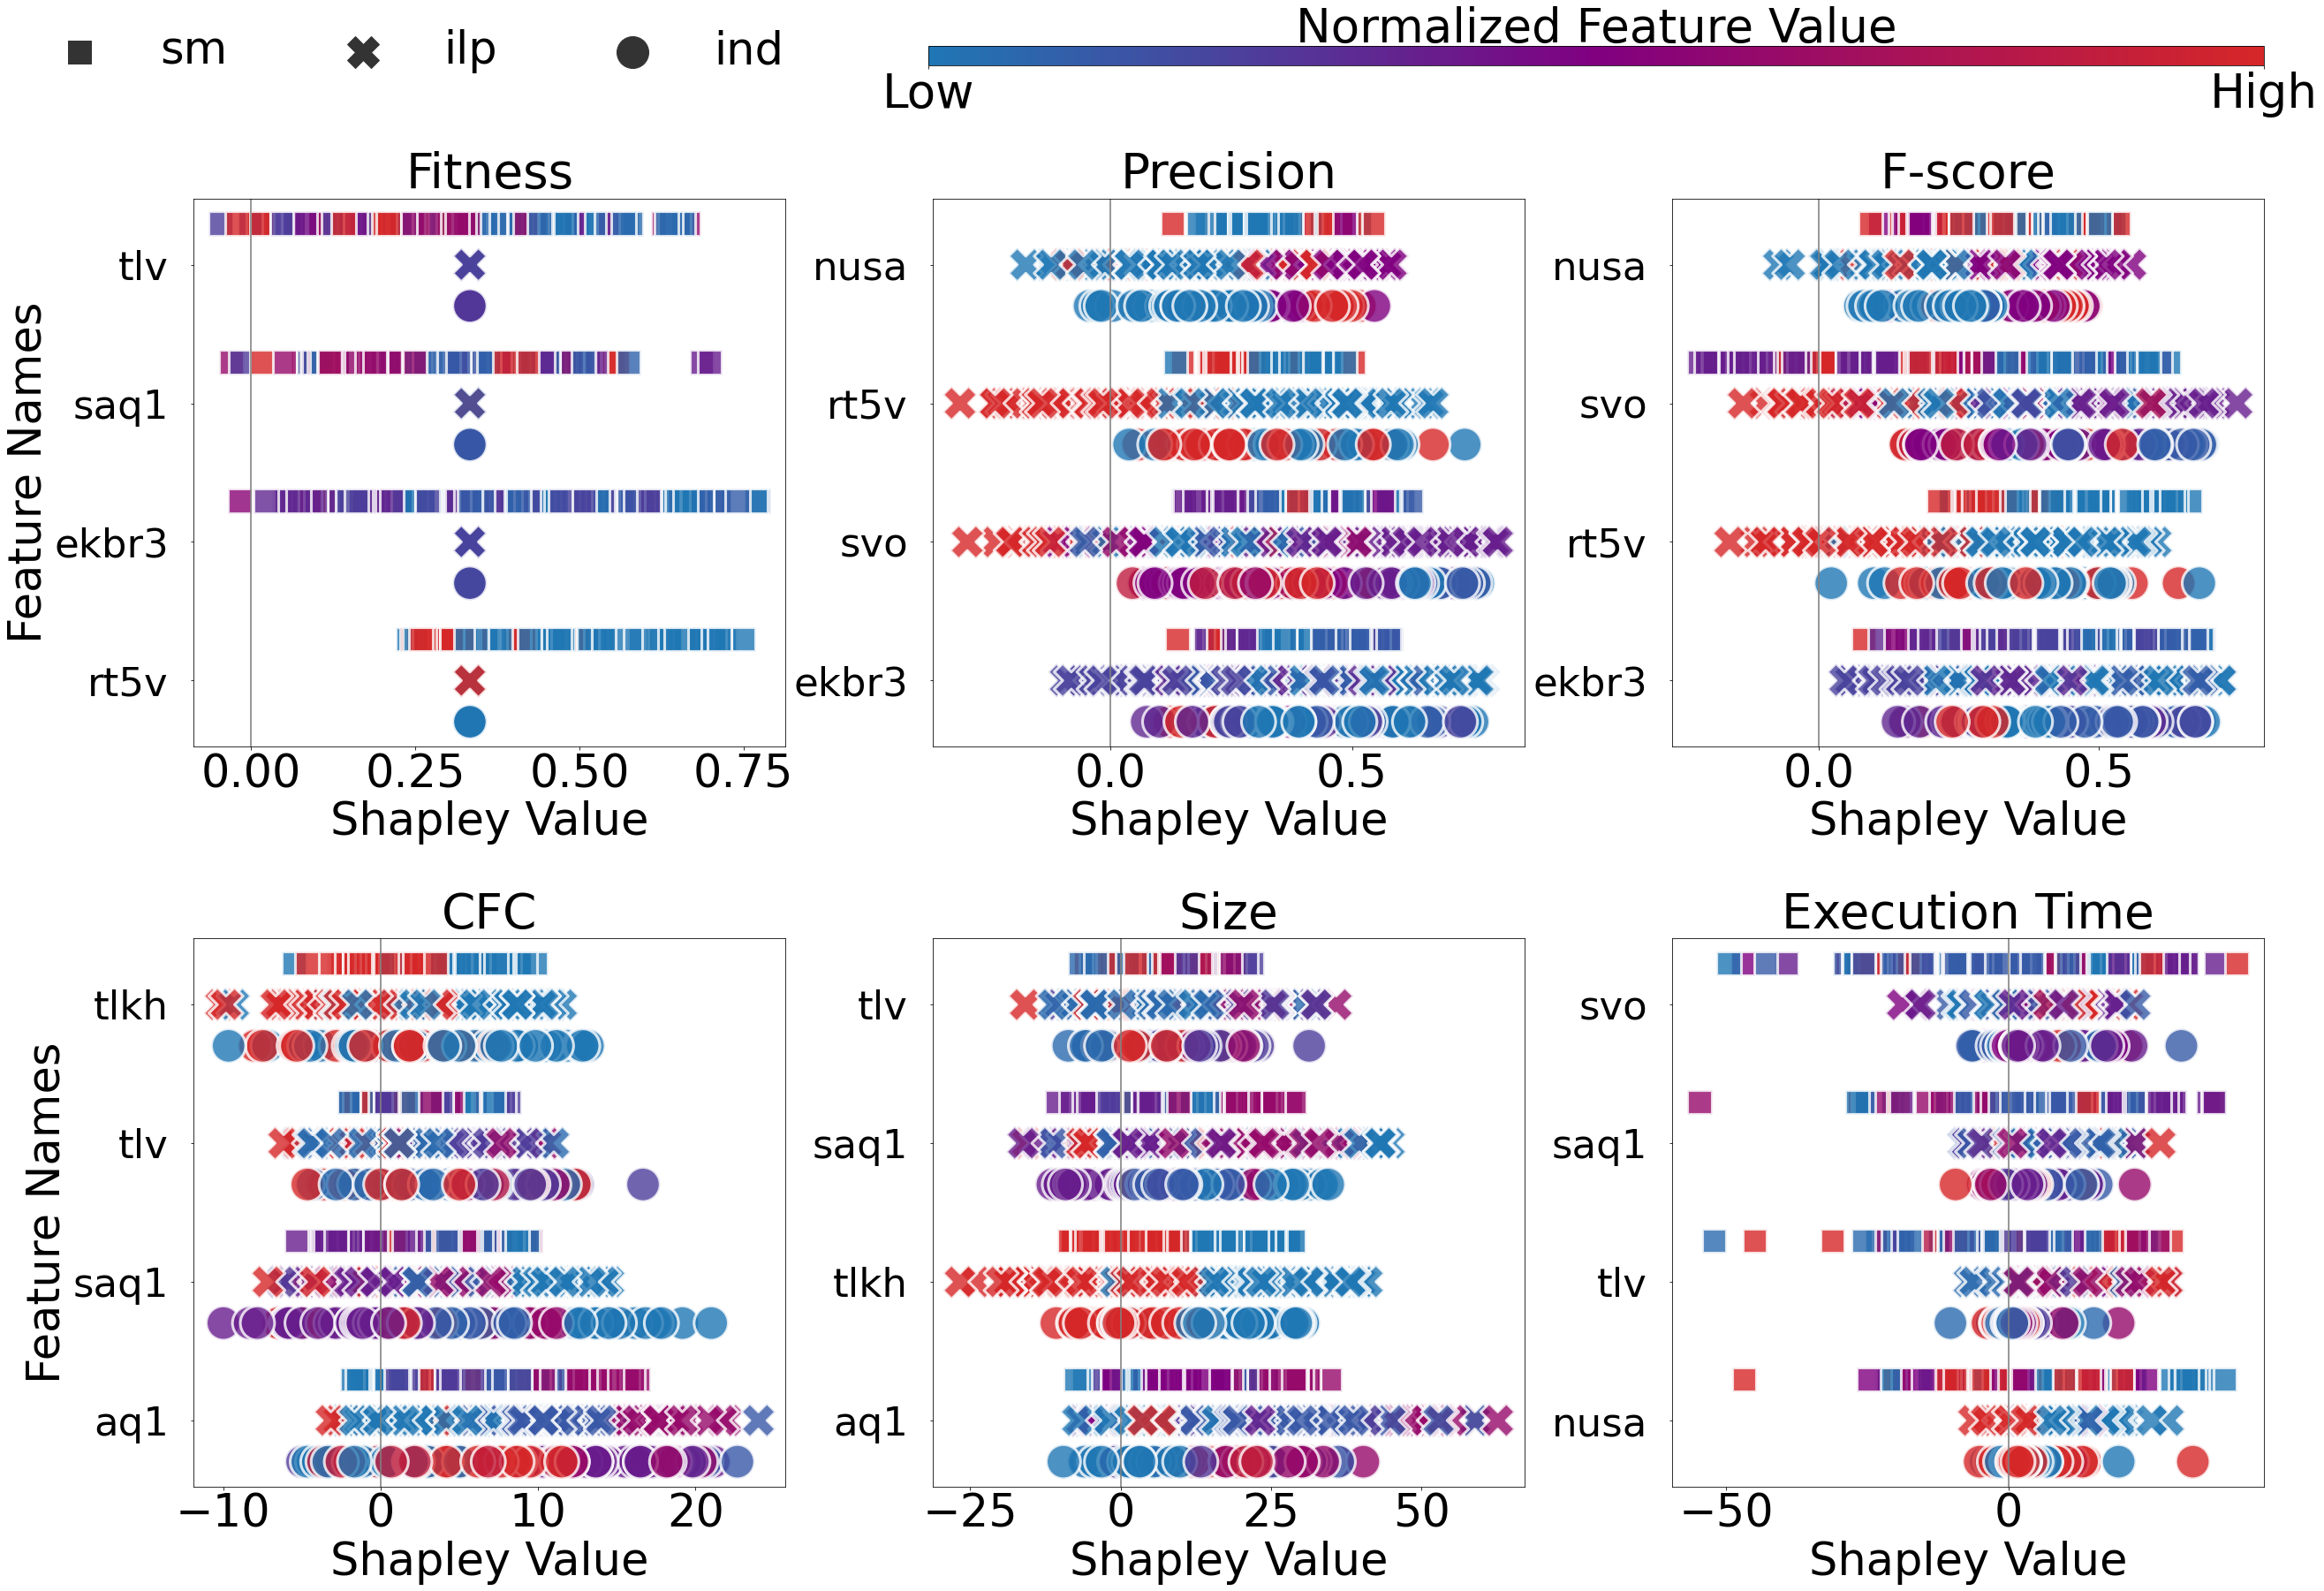

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

# Load data
data_path = INPUT_PATH
data = pd.read_csv(data_path)

data['feature_value'] = data['feature_value'].apply(lambda x: str(x))
data['feature_value'] = data['feature_value'].apply(reverse_processed_value, decimal_places=2)

# Normalize feature values
data["normalized_feature_value"] = data.groupby("feature_name")["feature_value"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

FONTSIZE = 55
TOP_N=4
mpl.rcParams['xtick.labelsize'] = FONTSIZE - 4  

# Define custom SHAP-like colormap
shap_blue = "#1F77B4"
shap_red = "#D62728"
colors = [shap_blue, "purple", shap_red]
custom_cmap = LinearSegmentedColormap.from_list("BluePurpleRed", colors, N=256)

# Define ordered metrics and titles
metrics = ["fitness", "precision", "fscore", "cfc", "size", "exectime"]
metric_titles = ["Fitness", "Precision", "F-score", "CFC", "Size", "Execution Time"]
algorithm_order = ["sm1", "ilp", "inductive"]
algorithm_order = algorithm_order[::-1]
data['algorithm'] = pd.Categorical(data['algorithm'], categories=algorithm_order, ordered=True)
data = data.sort_values(by='algorithm')

fig, axes = plt.subplots(2, 3, figsize=(42, 30))  
axes = axes.flatten()

fig.patch.set_facecolor('white')  
for ax in axes:
    ax.set_facecolor('white')  

fig.subplots_adjust(top=0.8, hspace=0.35, wspace=0.25)  

jitter_map = {algo: i * 1.1 for i, algo in enumerate(algorithm_order)}  

legend_handles = []

for idx, (ax, met, title) in enumerate(zip(axes, metrics, metric_titles)):
    # Filter data for the current metric
    viz_data = data[data['metric'] == met].copy()

    # Select top 4 features per metric based on absolute mean Shapley values
    top_features = (
        viz_data.groupby("feature_name")["shapley_value"]
        .mean()
        .abs()
        .nlargest(TOP_N)
        .index
    )
    #top_features = top_features.sort_values(ascending=False).index.sort_values()

    viz_data = viz_data[viz_data['feature_name'].isin(top_features)]
    
    # Order feature names based on `top_features`
    viz_data['feature_name'] = pd.Categorical(
        viz_data['feature_name'], 
        categories=top_features,  # Order features as they appear in `top_features`
        ordered=True
    )

    # Sort the data accordingly
    viz_data = viz_data.sort_values(by="feature_name")

    # Assign y-axis positions for features
    feature_codes = viz_data['feature_name'].astype("category").cat.codes * 3.7  

    for algo in algorithm_order:
        mask = viz_data['algorithm'] == algo
        viz_data.loc[mask, 'y_jitter'] = feature_codes[mask] + jitter_map[algo]

    # Create scatter plot
    scatter = sns.scatterplot(
        data=viz_data,
        x="shapley_value",
        y="y_jitter",
        hue="normalized_feature_value",
        style="algorithm",
        palette=custom_cmap,
        s=1500,
        alpha=0.8,
        ax=ax
    )

    # Draw vertical reference line at x=0
    ax.axvline(0, linestyle='-', color='gray', linewidth=2, alpha=0.8)

    # Set axis labels
    ax.set_xlabel("Shapley Value", fontsize=FONTSIZE-4)  
    ax.set_ylabel("Feature Names" if idx % 3 == 0 else "", fontsize=FONTSIZE-4)  
    ax.set_title(title, fontsize=FONTSIZE)

    # Adjust y-axis tick labels to show only the selected features
    mean_positions = viz_data.groupby("feature_name")["y_jitter"].mean()
    ax.set_yticks(mean_positions.values)
    ax.set_yticklabels(mean_positions.index, fontsize=FONTSIZE-10)  
    ax.yaxis.set_tick_params(pad=25)  
    ax.tick_params(axis='x', labelsize=FONTSIZE-4)

    # Capture legend handles once
    if not legend_handles:
        legend_handles, legend_labels = scatter.get_legend_handles_labels()
    
    ax.legend_.remove()

# Remove empty plots
for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

# Adjust legend labels (e.g., shorten 'inductive' to 'ind')
legend_labels = [label if label != 'inductive' else 'ind' for label in legend_labels]
legend_labels = [label if label != 'sm1' else 'sm' for label in legend_labels]

fig.legend(
    handles=legend_handles[-len(algorithm_order):][::-1],
    labels=legend_labels[-len(algorithm_order):][::-1],
    loc="upper left",  
    bbox_to_anchor=(0.05, 0.91),
    ncol=3,  
    markerscale=6,
    fontsize=FONTSIZE-4,  
    frameon=False  
)

# Add color bar
cbar_ax = fig.add_axes([0.4, 0.87, 0.5, 0.01])  
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([0, 1])  
cbar.set_ticklabels(['Low', 'High'], fontsize=FONTSIZE-2)  
cbar.set_label('Normalized Feature Value', fontsize=FONTSIZE-2)  
cbar.ax.xaxis.set_label_position('top')  

plt.show()

## Beeswarm plots for impact of all analysed features

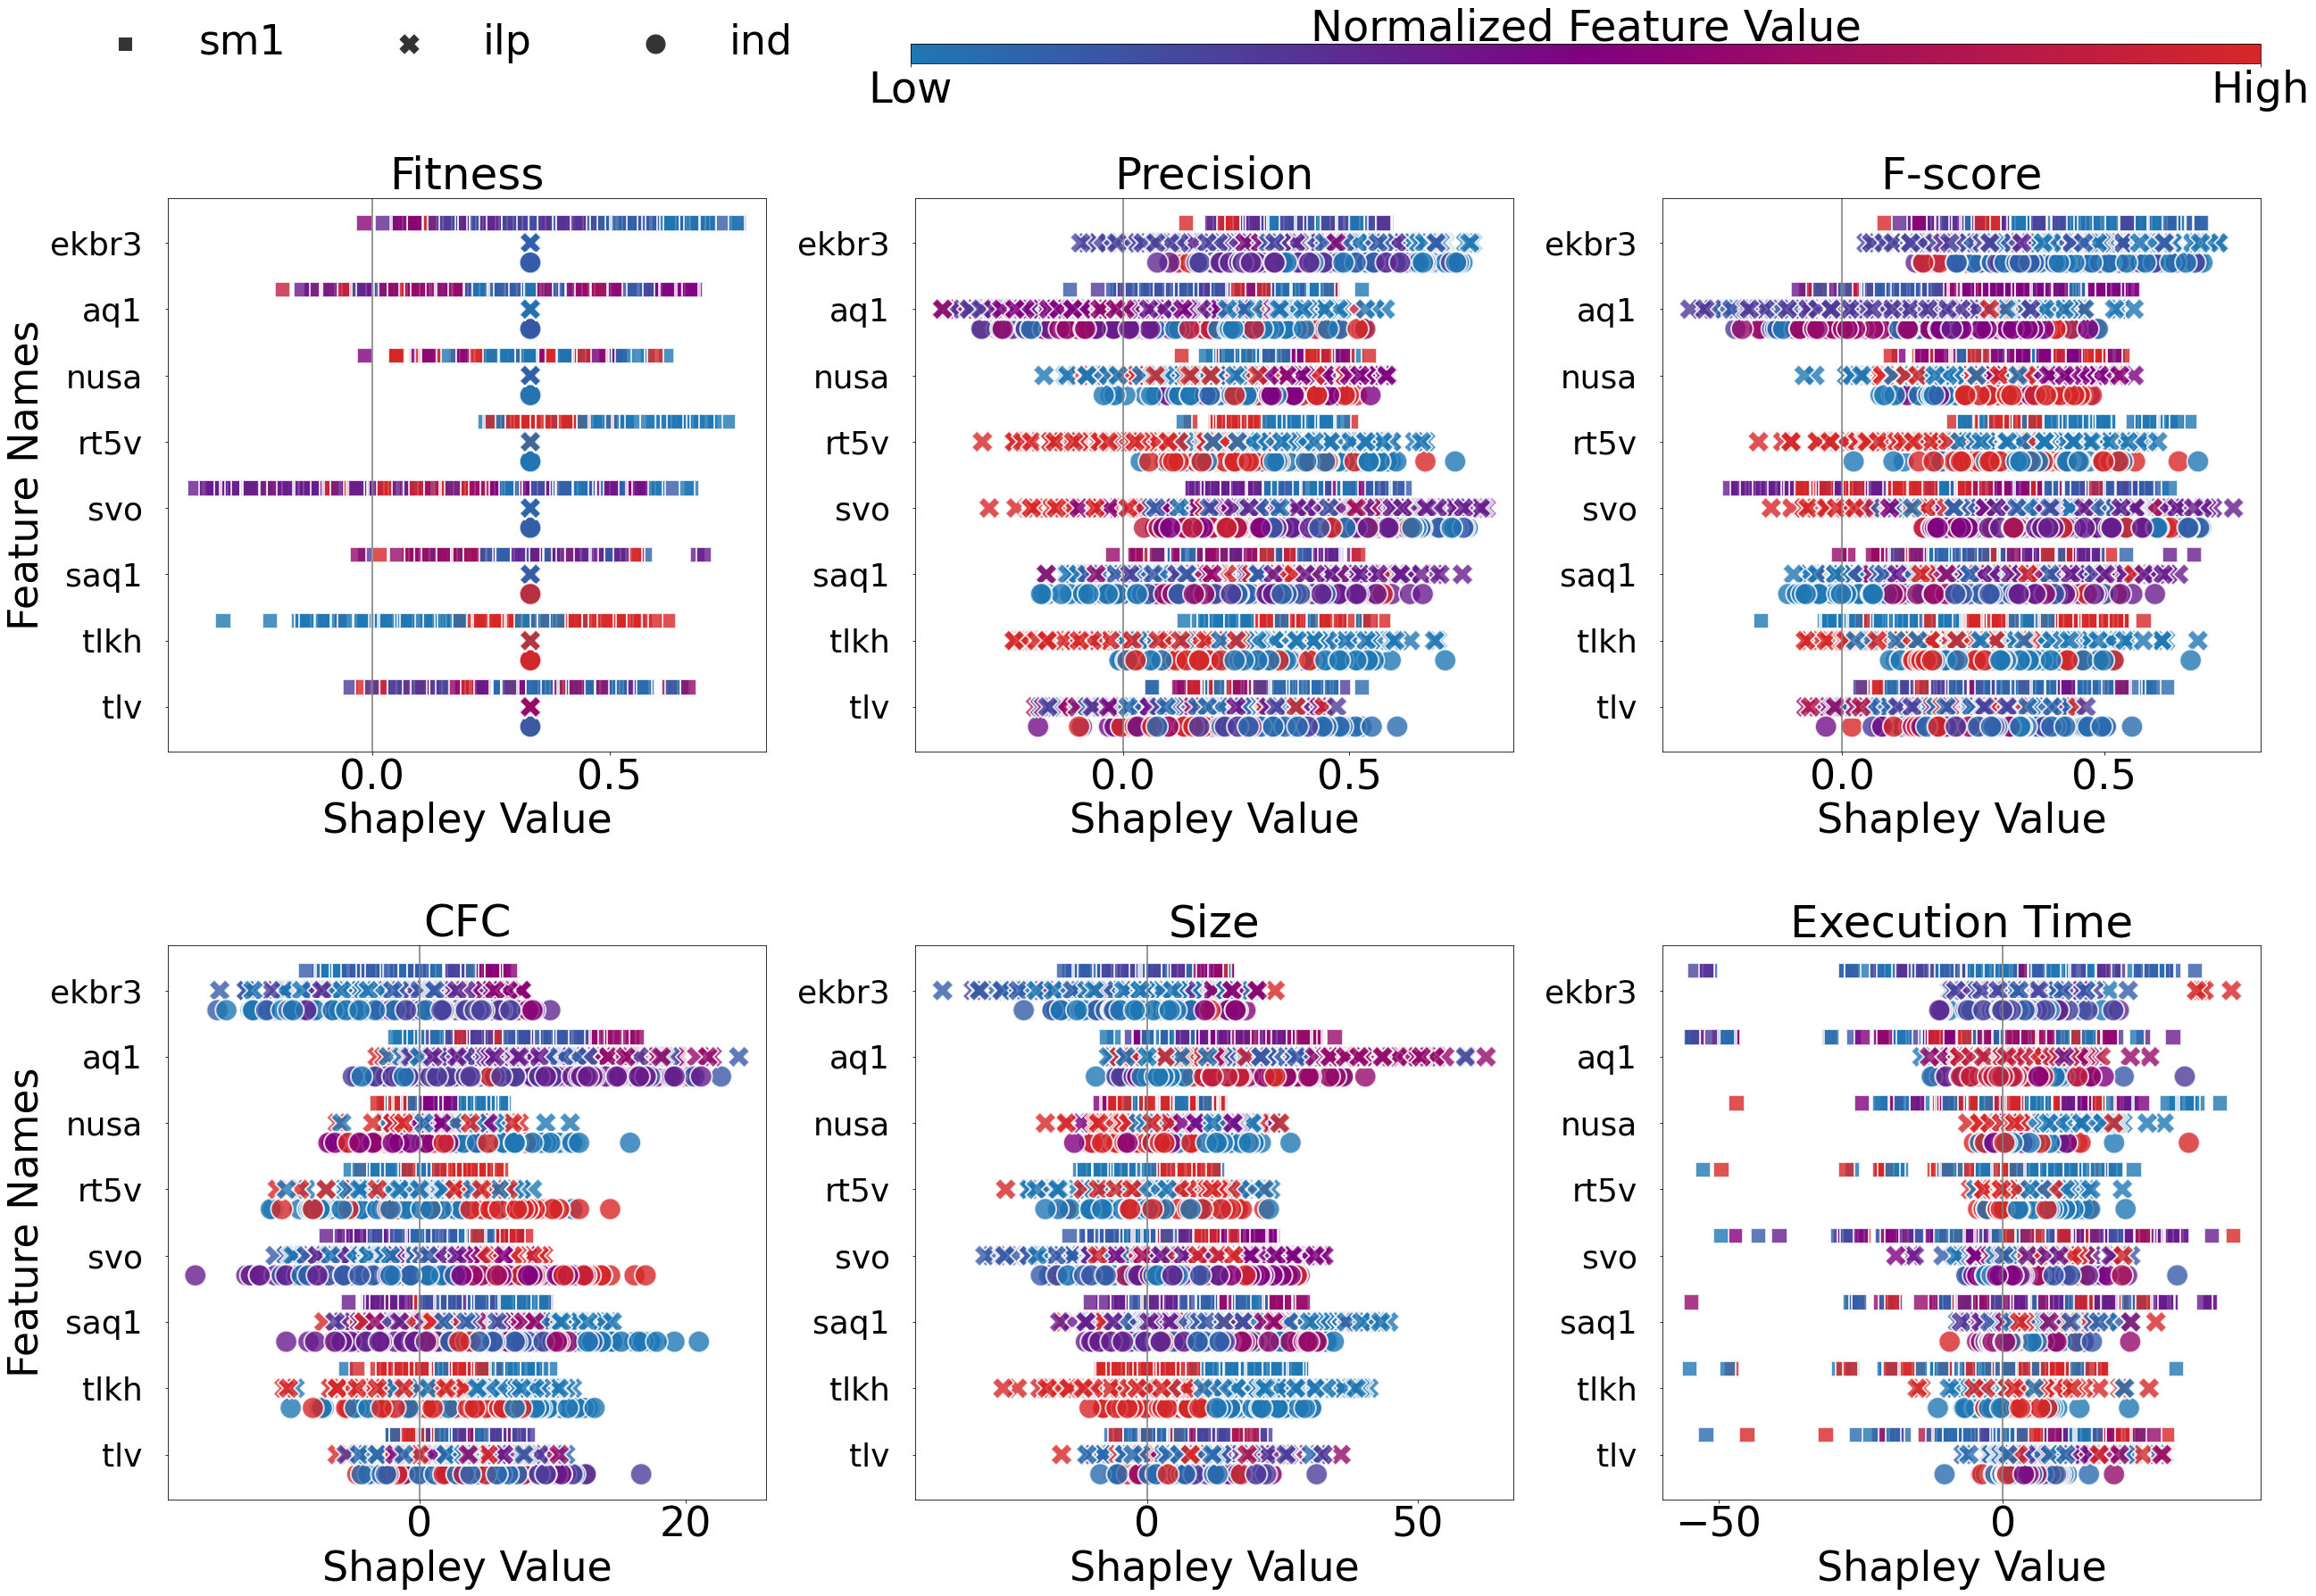

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

# Load data
data_path = INPUT_PATH
data = pd.read_csv(data_path)

data['feature_value'] = data['feature_value'].apply(lambda x: str(x))
data['feature_value'] = data['feature_value'].apply(reverse_processed_value, decimal_places=2)

# Normalize feature values
data["normalized_feature_value"] = data.groupby("feature_name")["feature_value"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

FONTSIZE = 50
mpl.rcParams['xtick.labelsize'] = FONTSIZE - 4  

# Define custom SHAP-like colormap
shap_blue = "#1F77B4"
shap_red = "#D62728"
colors = [shap_blue, "purple", shap_red]
custom_cmap = LinearSegmentedColormap.from_list("BluePurpleRed", colors, N=256)

# Define ordered metrics and titles
metrics = ["fitness", "precision", "fscore", "cfc", "size", "exectime"]
metric_titles = ["Fitness", "Precision", "F-score", "CFC", "Size", "Execution Time"]
algorithm_order = ["sm1", "ilp", "inductive"]
algorithm_order = algorithm_order[::-1]
data['algorithm'] = pd.Categorical(data['algorithm'], categories=algorithm_order, ordered=True)
data = data.sort_values(by='algorithm')
algorithms = data['algorithm'].unique()

# Sort feature names in the desired order
feature_order = ["ekbr3", "aq1", "nusa", "rt5v", "svo", "saq1", "tlkh", "tlv"]
feature_order = feature_order[::-1]
data['feature_name'] = pd.Categorical(data['feature_name'], categories=feature_order, ordered=True)
data = data.sort_values(by='feature_name')

fig, axes = plt.subplots(2, 3, figsize=(42, 30))  
axes = axes.flatten()

fig.patch.set_facecolor('white')  
for ax in axes:
    ax.set_facecolor('white')  

fig.subplots_adjust(top=0.8, hspace=0.35, wspace=0.25)  

jitter_map = {algo: i * 1.1 for i, algo in enumerate(algorithms)}  

legend_handles = []

for idx, (ax, met, title) in enumerate(zip(axes, metrics, metric_titles)):
    viz_data = data[data['metric'] == met].copy()
    
    feature_codes = viz_data['feature_name'].astype("category").cat.codes * 3.7  

    for algo in algorithms:
        mask = viz_data['algorithm'] == algo
        viz_data.loc[mask, 'y_jitter'] = feature_codes[mask] + jitter_map[algo]
    
    scatter = sns.scatterplot(
        data=viz_data,
        x="shapley_value",
        y="y_jitter",
        hue="normalized_feature_value",
        style="algorithm",
        palette=custom_cmap,
        s=600,
        alpha=0.8,
        ax=ax
    )
    ax.axvline(0, linestyle='-', color='gray', linewidth=2, alpha=0.8)
    ax.set_xlabel("Shapley Value", fontsize=FONTSIZE-4)  
    
    if idx % 3 == 0:
        ax.set_ylabel("Feature Names", fontsize=FONTSIZE-4)
    else:
        ax.set_ylabel("")  
    
    ax.set_title(title, fontsize=FONTSIZE)

    mean_positions = viz_data.groupby("feature_name")["y_jitter"].mean()
    
    ax.set_yticks(mean_positions.values)
    ax.set_yticklabels(mean_positions.index, fontsize=FONTSIZE-14)  
    
    ax.yaxis.set_tick_params(pad=25)  

    ax.tick_params(axis='x', labelsize=FONTSIZE-4)

    if not legend_handles:
        legend_handles, legend_labels = scatter.get_legend_handles_labels()
    
    ax.legend_.remove()

for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

legend_labels = [label if label != 'inductive' else 'ind' for label in legend_labels]
fig.legend(
    handles=legend_handles[-len(algorithms):][::-1],
    labels=legend_labels[-len(algorithms):][::-1],
    loc="upper left",  
    bbox_to_anchor=(0.08, 0.91),
    ncol=3,  
    markerscale=3.5,
    fontsize=FONTSIZE-4,  
    frameon=False  
)

cbar_ax = fig.add_axes([0.4, 0.87, 0.5, 0.01])  

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1))
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([0, 1])  
cbar.set_ticklabels(['Low', 'High'], fontsize=FONTSIZE-2)  
cbar.set_label('Normalized Feature Value', fontsize=FONTSIZE-2)  
cbar.ax.xaxis.set_label_position('top')  

output_dir = os.path.join("..","output", "figures")

plt.show()

### Highlights per metric:
**Fitness** improves for sm with higher tlkh (trace length kurtosis), indicating that frequent trace length outliers enhance fitness. Conversely, rt5v (ratio
of top-5 variants) negatively impacts fitness, suggesting that fewer dominant
variants are beneficial. Algorithms ilp and ind remain stable, unaffected by log
structure as previously discussed. For precision, high rt5v values have a diminishing impact, especially in ilp, as shown by negative Shapley values. In contrast,
medium-to-high nusa (number of unique start activities) values improves precision across all algorithms. Low to medium values for tlkh and svo (skewness of
variant occurrence) also impact precision positively, though ilp and ind exhibit
inverse trends to sm. This is likely due to ilp and ind’s focus on maximizing Fitness, which benefits from simpler logs, while sm balances Fitness and Precision,
where simpler logs may hinder optimal performance of both. Since the F-Score
balances fitness and precision, its trends follow those metrics. Low ekbr3 and
aq1 values enhance F-Score, reinforcing that lower entropy and simpler activity
distribution aid process discovery. Similar to precision, rt5v negatively impacts
F-Score, with sm and ilp showing the strongest trends, while ind remains more
stable.


**Complexity** metrics (cfc and size) show clearer feature impact trends than
quality metrics. The metric cfc fluctuates based on values for multiple features,
as seen in its symmetrical Shapley distribution around zero. Notably, nusa (number of unique start activities) inversely correlates with cfc, which means that
fewer start activities increase complexity by entangling flows, while more promote well-separated subprocesses. Likewise, svo (skewness variant occurrence)
amplifies complexity, suggesting that uneven case variant distribution leads to
more intricate models. Among algorithms, ilp shows the highest variance, indicating sensitivity to feature changes, while sm remains more stable. Model size
follows similar trends to cfc, given their trends. However, in this case, ind is
more stable than ilp, the opposite of what is observed for cfc.

**Execution Time** is heavily impacted by high ekbr3 and tlkh values, which create complex log
structures requiring more processing. Although execution time may be stable
on average for sm, outliers arise from its adaptive heuristic approach, leading
to unpredictable runtimes with complex logs. In contrast, ind shows more stable execution times, indicating consistent performance across feature variations.